<a href="https://colab.research.google.com/github/youngwow/VK-test/blob/master/VK_internship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание

Для данного задания предлагается использовать полный датасет
MovieLens (https://grouplens.org/datasets/movielens/latest/)

Необходимо построить векторные представления (эмбеддинги)
пользователей и фильмов используя **нейросетевые подходы**, чтобы
можно было *по эмбеддингу пользователя искать похожие эмбеддинги
фильмов и рекомендовать ему их*.

При выполнении задания обратите внимание на:
1. Разбиение данных на обучение и валидацию, обоснование
2. Выбор и обоснование метрики
3. Разработка архитектуры нейронной сети с пояснениями
4. Обучение и валидация
5. Решение должно быть воспроизводимым, в формате Jupyter
Notebook (Google Colab / файл на Github) с подробными пояснениями
на каждом шаге

В ответе прикрепить ссылку на GoogIe Colab notebook решение
(проверьте настройки приватности!) или ссылку на Github репозиторий с
Jupyter Notebook решением.

# Начало работы

## Загрузим данные

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest.zip -O ml-latest.zip
import zipfile
import os


directory = 'ml-latest'
if not os.path.isdir(directory):
    with zipfile.ZipFile("ml-latest.zip", 'r') as zip_ref:
        zip_ref.extractall()

--2023-05-10 11:52:35--  https://files.grouplens.org/datasets/movielens/ml-latest.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 277113433 (264M) [application/zip]
Saving to: ‘ml-latest.zip’

ml-latest.zip       100%[===================>] 264.28M  28.8MB/s    in 9.9s    

2023-05-10 11:52:45 (26.8 MB/s) - ‘ml-latest.zip’ saved [277113433/277113433]



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
FOLDER = '/content/ml-latest'

# genome_scores = pd.read_csv(FOLDER + '/genome-scores.csv')
# genome_tags = pd.read_csv(FOLDER + '/genome-tags.csv')
# links = pd.read_csv(FOLDER + '/links.csv')
movies = pd.read_csv(FOLDER + '/movies.csv')
ratings = pd.read_csv(FOLDER + '/ratings.csv')
# tags = pd.read_csv(FOLDER + '/tags.csv')

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
print(ratings.isna().sum())
print()
print(movies.isna().sum())

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

movieId    0
title      0
genres     0
dtype: int64


## Обзор данных

Из данных видно, что DataFrame *ratings* имеет 4 колонки: userId, movieId, rating, timestamp

- userId - идентификатор пользователя
- movieId - идентификатор фильма
- rating - какую оценку дал пользователь (userId) фильму (movieId). Рейтинг находится в диапазоне от 0.5 до 5 с шагом 0.5, т.е. имеет значения 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5.
- timestamp - время, когда пользователь поставил оценку.

DataFrame *movies* имеет 3 колонки: movieId, title, genres:
- movieId - идентификатор фильма
- title - название фильма
- genres - жанры фильма. Принимает следующие значения: (no genres listed), Action, Adventure, Animation, Children, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, IMAX, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western.

Также мы сделали проверку на NaN значения в данных и оказалось, что их нет.

Переведём timestamp к типу данных DataTime. Это нам поможет разбить данные на тренировочную и валидационную выборку: в тренировочном наборе данных будут содержаться более старые данные, а в валидационном наборе данных будут содержаться относительно свежие данные. Таким образом, мы проверим как будет вести себя модель на более свежих данных.

In [ ]:
ratings['day'] = pd.to_datetime(ratings['timestamp'], unit='s').dt.date
ratings = ratings.drop(['timestamp'], axis=1)
ratings.head()

,userId,movieId,rating,day
0,1,307,3.5,2009-10-27
1,1,481,3.5,2009-10-27
2,1,1091,1.5,2009-10-27
3,1,1257,4.5,2009-10-27
4,1,1449,4.5,2009-10-27


In [ ]:
ratings = ratings.merge(ratings.groupby('userId', as_index=False).agg({'movieId':'count'}).rename(columns=
                               {'movieId': 'count_movies'}), on='userId')

ratings['count_movies'].describe()

count    2.775344e+07
mean     5.599458e+02
std      1.006932e+03
min      1.000000e+00
25%      1.120000e+02
50%      2.940000e+02
75%      6.740000e+02
max      2.371500e+04
Name: count_movies, dtype: float64

In [ ]:
percentile_90 = ratings['count_movies'].quantile(0.9)
percentile_25 = ratings['count_movies'].quantile(0.25)
print("90th percentile: {}\n25th percentile: {}".format(percentile_90, percentile_25))

90th percentile: 1292.0
25th percentile: 112.0


## Очистка данных

Рассмотрев количество оценок фильмов, выясняется, что медианное значение оценок на одного пользователя составляет 294, а 90% пользователей оценили количество фильмов, не превышающее 1292, в то время как 25% пользователей оценили менее 112 фильмов. 

Стоит отметить, что наибольшее количество оценок, которое было выставлено одним пользователем, равняется 23715.

Допустим, что пользователи, у которых уровень активности находится ниже 25-го процентиля, представляют группу, о которой мы не имеем достаточной информации, а те, кто выше 90-го процентиля, скорее всего являются ботами.

In [ ]:
ratings = ratings[(ratings.count_movies > percentile_25) & (ratings.count_movies < percentile_90)]
ratings = ratings.drop(['count_movies'], axis=1)
ratings.head()

,userId,movieId,rating,day
42,4,1,4.0,2005-04-17
43,4,2,4.0,2005-04-17
44,4,5,2.0,2005-08-14
45,4,6,4.5,2005-04-17
46,4,10,4.0,2005-04-17


In [ ]:
# min and max ratings will be used to normalize the ratings later
min_rating = ratings["rating"].min()
max_rating = ratings["rating"].max()

print("Min rating: {}, Max rating: {}".format(min_rating, max_rating))
# Normalize the targets between 0 and 1. Makes it easy to train.
ratings["rating"] = ratings["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating))
ratings.head()

Min rating: 0.5, Max rating: 5.0


,userId,movieId,rating,day
42,4,1,0.777778,2005-04-17
43,4,2,0.777778,2005-04-17
44,4,5,0.333333,2005-08-14
45,4,6,0.888889,2005-04-17
46,4,10,0.777778,2005-04-17



Для того, чтобы ускорить сходимость алгоритма к оптимальному решению, необходимо привести рейтинг фильмов к диапозону [0; 1] путем их нормализации.

In [ ]:
# sort data by timestamp
ratings = ratings.sort_values(by='day')

# calculate the index for the split
split_index = int(0.9 * ratings.shape[0])

# split data into training and validation sets
train_set = ratings[:split_index]
val_set = ratings[split_index:]

all_users = ratings["userId"].unique() 
all_movies = ratings["movieId"].unique()

<Axes: xlabel='day'>

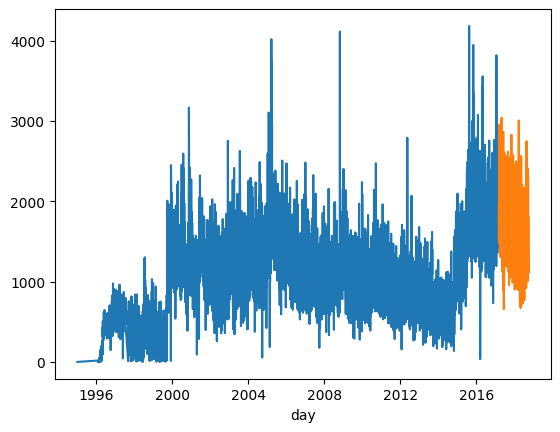

In [ ]:
train_set.groupby(['day'])['movieId'].nunique().plot()
val_set.groupby(['day'])['movieId'].nunique().plot()

## Разбиение данных на обучение и валидацию, обоснование

На графике можно заметить, что тренировочная выборка обозначена синим цветом, в то время как валидационная выборка обозначена оранжевым цветом. В тренировочном наборе данных присутствуют данные, собранные более давно, в то время как в валидационном наборе данных находятся более свежие данные. Такой подход позволит оценить работу модели на более новых данных.

In [ ]:
hidden_units = (32,4)
EMBEDDING_SIZE = 8

# Each instance will consist of two inputs: a single user id, and a single movie id
user_input = tf.keras.layers.Input(shape=(1,),
                                   name="user")

user_as_integer = tf.keras.layers.IntegerLookup(vocabulary=all_users, 
                                                name="user_as_integer")(user_input)

user_embedding = tf.keras.layers.Embedding(input_dim=len(all_users) + 1, 
                                           output_dim=EMBEDDING_SIZE, 
                                           name="user_embedding")(user_as_integer)

user_bias = tf.keras.layers.Embedding(input_dim=len(all_users) + 1, 
                                      output_dim=1, name="user_bias")(user_as_integer)


movie_input = tf.keras.layers.Input(shape=(1,),
                                    name="movie")

movie_as_integer = tf.keras.layers.IntegerLookup(vocabulary=all_movies,
                                                 name="movie_as_integer")(movie_input)

movie_embedding = tf.keras.layers.Embedding(input_dim=len(all_movies) + 1,
                                            output_dim=EMBEDDING_SIZE,
                                            name="movie_embedding")(movie_as_integer)

movie_bias = tf.keras.layers.Embedding(input_dim=len(all_movies) + 1,
                                       output_dim=1, name="movie_bias")(movie_as_integer)

dot = tf.keras.layers.Dot(axes=2,
                          name="dot_product")([user_embedding, movie_embedding])

add = tf.keras.layers.Add(name="sum")([dot, user_bias, movie_bias])
out = tf.keras.layers.Flatten(name="flatten")(add)

# Add one or more hidden layers
for n_hidden in hidden_units:
    out = tf.keras.layers.Dense(n_hidden, activation='relu')(out)

# A single output: our predicted rating
out = tf.keras.layers.Dense(1, activation='linear', name='prediction')(out)

model = tf.keras.Model(
    inputs = [user_input, movie_input],
    outputs = out,
)
model.summary(line_length=88)

Model: "model"
________________________________________________________________________________________
 Layer (type)                Output Shape       Param #   Connected to                  
 user (InputLayer)           [(None, 1)]        0         []                            
                                                                                        
 movie (InputLayer)          [(None, 1)]        0         []                            
                                                                                        
 user_as_integer (IntegerLoo  (None, 1)         0         ['user[0][0]']                
 kup)                                                                                   
                                                                                        
 movie_as_integer (IntegerLo  (None, 1)         0         ['movie[0][0]']               
 okup)                                                                                  
      

## Разработка архитектуры нейронной сети с пояснениями

Мы создаем векторные представления (эмбеддинги) для каждого пользователя и фильма на основе переменных userId и movieId. Эти векторные представления имеют одинаковую длину, и при использовании скалярного произведения мы можем получить оценку фильма от пользователя.

Кроме того, мы также создаем смещение для каждого пользователя и фильма. Это позволяет учитывать тенденции пользователей к более положительным или отрицательным оценкам, а также учитывать фильмы, которые получают только положительные или отрицательные оценки. В результате получаем более точные и релевантные оценки фильмов.

В дополнение к этому, мы используем 2 полносвязных слоя для того, чтобы дополнительно обработать и объединить информацию, полученную из векторных представлений и смещений. Эти слои помогают модели более точно предсказывать оценки пользователей для фильмов, учитывая их индивидуальные предпочтения и поведение. Кроме того, использование полносвязных слоев позволяет модели изучать более сложные зависимости между факторами, влияющими на оценки фильмов. В итоге, мы получаем более точную модель рекомендательной системы, которая может помочь пользователям в выборе подходящих фильмов на основе их предпочтений.

Помимо этого, полносвязные слои были добавлены для того, чтобы иметь возможность учитывать дополнительные факторы, такие как жанр фильма. Несмотря на то, что в текущей работе это не было использовано, в будущем такая возможность может оказаться полезной.

Таким образом, мы можем делать предсказания для фильмов, которые пользователь не посмотрел. Отсортировать рейтинги по убыванию и выбрать ТОП-N рекомендаций для пользователя.

In [ ]:
METRICS = [
          tf.keras.metrics.MeanAbsoluteError(name='mae'),
          tf.keras.metrics.MeanSquaredError(name='mse'),
          tf.keras.metrics.TruePositives(name='tp'),
          tf.keras.metrics.FalsePositives(name='fp'),
          tf.keras.metrics.TrueNegatives(name='tn'),
          tf.keras.metrics.FalseNegatives(name='fn'), 
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall')
    ]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=METRICS,
)

## Выбор и обоснование метрики

Поскольку мы решаем задачу регрессии, мы выбрали MSE в качестве функции потерь. MAE позволяет оценить среднее абсолютное отклонение предсказанных значений от истинных значений, а MSE показывает среднеквадратичное отклонение. Важно отметить, что эти метрики позволяют оценить не только точность модели, но и ее устойчивость к выбросам в данных. Таким образом, при обучении и оценки модели необходимо уделять особое внимание этим метрикам.

In [ ]:
history = model.fit(
    x={"user": train_set["userId"], "movie": train_set["movieId"]},
    y=train_set["rating"].values,
    batch_size=5000,
    epochs=20,
    verbose=1,
    validation_split=0.05,
)

Epoch 1/20
3080/3080 [==============================] - 166s 51ms/step - loss: 0.0354 - mae: 0.1426 - mse: 0.0354 - tp: 13410882.0000 - fp: 82066.0000 - tn: 126825.0000 - fn: 1779009.0000 - precision: 0.9939 - recall: 0.8829 - val_loss: 0.0476 - val_mae: 0.1692 - val_mse: 0.0476 - val_tp: 735306.0000 - val_fp: 12781.0000 - val_tn: 5132.0000 - val_fn: 57244.0000 - val_precision: 0.9829 - val_recall: 0.9278
Epoch 2/20
3080/3080 [==============================] - 40s 13ms/step - loss: 0.0296 - mae: 0.1313 - mse: 0.0296 - tp: 13266803.0000 - fp: 56793.0000 - tn: 152098.0000 - fn: 1923088.0000 - precision: 0.9957 - recall: 0.8734 - val_loss: 0.0475 - val_mae: 0.1687 - val_mse: 0.0475 - val_tp: 737124.0000 - val_fp: 12839.0000 - val_tn: 5074.0000 - val_fn: 55426.0000 - val_precision: 0.9829 - val_recall: 0.9301
Epoch 3/20
3080/3080 [==============================] - 36s 12ms/step - loss: 0.0288 - mae: 0.1293 - mse: 0.0288 - tp: 13229768.0000 - fp: 51546.0000 - tn: 157345.0000 - fn: 1960123.0

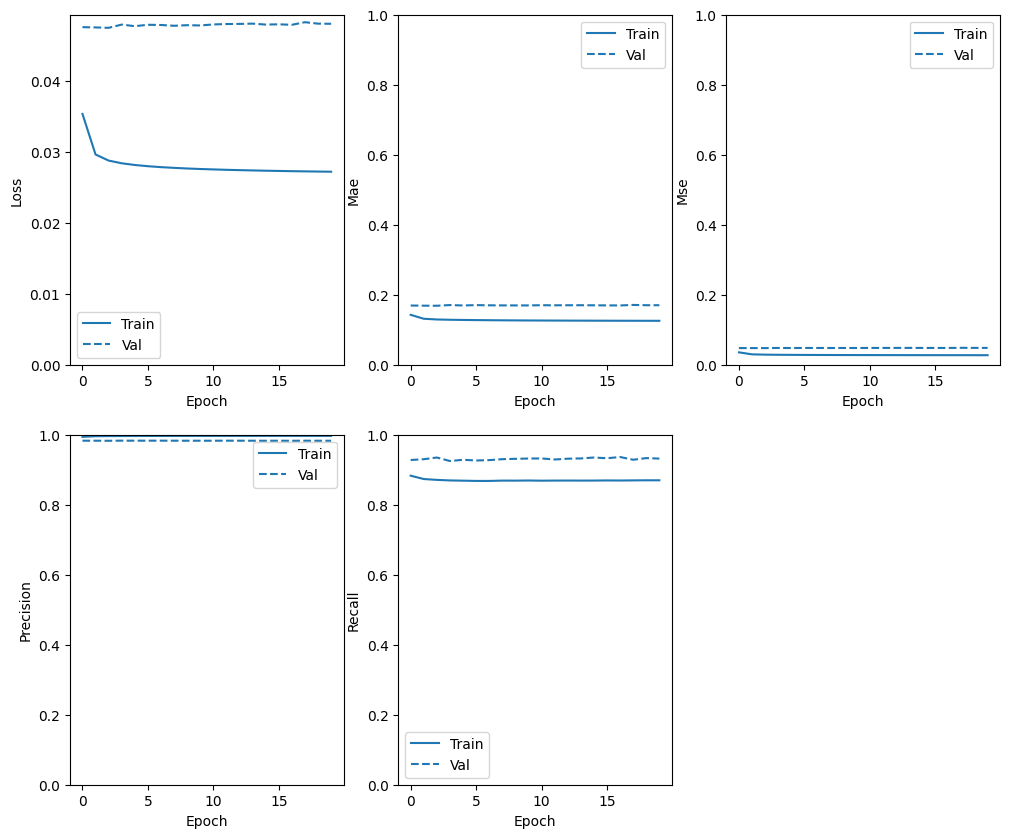

In [ ]:
import matplotlib as mpl

def plot_metrics(history):
        mpl.rcParams['figure.figsize'] = (12, 10)
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        metrics = ['loss', 'mae', 'mse', 'precision', 'recall']
        for n, metric in enumerate(metrics):
            name = metric.replace("_"," ").capitalize()
            plt.subplot(2,3,n+1)
            plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
            plt.plot(history.epoch, history.history['val_'+metric],
                     color=colors[0], linestyle="--", label='Val')
            plt.xlabel('Epoch')
            plt.ylabel(name)
            if metric == 'loss':
                plt.ylim([0, plt.ylim()[1]])
            elif metric == 'auc':
                plt.ylim([0.8,1])
            else:
                plt.ylim([0,1])

            plt.legend();
        plt.savefig('loss_accuracy_curve.png')
        plt.show()

plot_metrics(history)

## Оценка модели

Из графиков видно, что показатели MSE и MAE являются низкими, что говорит об относительно небольшой разнице между предсказанными и истинными значениями, что является положительным результатом.

Протестируем модель на каком-нибудь примере.

In [ ]:
val_set.groupby('userId', as_index=False).agg({'movieId':'count'}).rename(columns=
                               {'movieId': 'count_movies'}).head()

,userId,count_movies
0,14,13
1,36,149
2,48,170
3,67,127
4,75,139


Пользователь с userId = 14 посмотрел 13 фильмов из валидационной выборки. Используя модель, мы можем сделать предсказания рейтингов для всех фильмов и также для этих 13 фильмов. Из полученных результатов можно выбрать топ-5 фильмов для данного пользователя. Посмотрим результаты и сравним их. 

In [ ]:
val_set[val_set.userId == 14].sort_values(by='rating', ascending=False)

,userId,movieId,rating,day
1290,14,177765,1.000000,2018-03-26
1289,14,166024,0.888889,2017-06-15
1288,14,160718,0.888889,2018-03-26
1118,14,2,0.777778,2018-03-26
1172,14,7669,0.666667,2018-03-26
1200,14,64969,0.666667,2018-03-26
1142,14,2720,0.666667,2018-03-26
1137,14,1917,0.666667,2018-03-26
1276,14,114935,0.666667,2018-03-26
1233,14,90746,0.666667,2018-03-26


In [ ]:
user_ratings = train_set[train_set.userId == 14].sort_values(by='rating', ascending=False)
user_ratings.head()

,userId,movieId,rating,day
1201,14,68157,1.0,2015-09-13
1210,14,78499,1.0,2015-09-13
1224,14,86882,1.0,2015-09-13
1194,14,58559,1.0,2015-09-13
1153,14,4886,1.0,2015-09-13


In [ ]:
print("User #{} has rated {} movies (avg. rating = {:.1f}):".format(
    14, len(user_ratings), user_ratings['rating'].mean(),
))

User #14 has rated 161 movies (avg. rating = 0.8):


Пользователь посмотрел 161 фильм. Средняя оценка 4.1.

In [ ]:
# user_ids = np.array([14] * len(all_users))
# movie_ids = np.array(all_movies)

preds = model.predict([
    np.array([14] * len(all_movies)), # User ids 
    all_movies, # Movie ids
])

1317/1317 [==============================] - 4s 3ms/step


In [ ]:
preds

array([[0.7238337 ],
       [0.70514977],
       [0.75931185],
       ...,
       [0.68310034],
       [0.6849667 ],
       [0.6856848 ]], dtype=float32)

In [ ]:
movie_preds_user = pd.DataFrame({"movieId": all_movies, "prediction": np.squeeze(preds)})
movie_preds_user = movie_preds_user.sort_values(by='prediction', ascending=False)
movie_preds_user.head()

,movieId,prediction
127,318,0.917359
29212,159817,0.903997
22834,136447,0.901404
18584,107559,0.888331
29379,160289,0.884049


In [ ]:
top_5 = [318, 159817, 136447, 107559, 160289]
movies[movies['movieId'].isin(top_5)]

,movieId,title,genres
315,318,"Shawshank Redemption, The (1994)",Crime|Drama
22681,107559,Am Ende eiens viel zu kurzen Tages (Death of a...,Animation|Drama
32943,136447,George Carlin: You Are All Diseased (1999),Comedy
42845,159817,Planet Earth (2006),Documentary
43045,160289,O.J.: Made in America (2016),Documentary


Для данного пользователя мы можем сформулировать рекомендации по фильмам из списка выше.

In [ ]:
preds = model.predict([
    np.array([14] * val_set[val_set.userId == 14]['movieId'].nunique()), # User ids 
    val_set[val_set.userId == 14]['movieId'].unique(), # Movie ids
])

movie_preds_user = pd.DataFrame({"movieId": val_set[val_set.userId == 14]['movieId'],
                                 "prediction": np.squeeze(preds),
                                 "true_rating": val_set[val_set.userId == 14]['rating'],
                                 "abs(true-pred)": abs(val_set[val_set.userId == 14]['rating'] - np.squeeze(preds))
                                 }).sort_values(by='prediction', ascending=False)
movie_preds_user.head()

1/1 [==============================] - 0s 28ms/step


,movieId,prediction,true_rating,abs(true-pred)
1288,160718,0.834160,0.888889,0.054728
1172,7669,0.797577,0.666667,0.130910
1276,114935,0.740454,0.666667,0.073787
1233,90746,0.725105,0.666667,0.058439
1200,64969,0.699291,0.666667,0.032624


In [ ]:
movie_preds_user.describe()

,movieId,prediction,true_rating,abs(true-pred)
count,13.000000,13.000000,13.000000,13.000000
mean,65151.307692,0.663267,0.709402,0.102636
std,69645.168973,0.109113,0.140094,0.089429
min,2.000000,0.464423,0.555556,0.008945
25%,2720.000000,0.627055,0.666667,0.054728
50%,51086.000000,0.681524,0.666667,0.071499
75%,114935.000000,0.725105,0.777778,0.130910
max,177765.000000,0.834160,1.000000,0.315743


In [ ]:
movie_preds_user.tail()

,movieId,prediction,true_rating,abs(true-pred)
1137,1917,0.657722,0.666667,0.008945
1190,51086,0.627055,0.555556,0.071499
1166,6534,0.535905,0.555556,0.019651
1135,1882,0.500357,0.555556,0.055198
1142,2720,0.464423,0.666667,0.202243


In [ ]:
movie_preds_user['prediction'] = movie_preds_user['prediction'] * (max_rating - min_rating) + min_rating
movie_preds_user.head()

,movieId,prediction,true_rating,abs(true-pred)
1288,160718,4.253722,0.888889,0.054728
1172,7669,4.089097,0.666667,0.130910
1276,114935,3.832042,0.666667,0.073787
1233,90746,3.762974,0.666667,0.058439
1200,64969,3.646808,0.666667,0.032624


In [ ]:
movie_preds_user['true_rating'] = movie_preds_user['true_rating'] * (max_rating - min_rating) + min_rating
movie_preds_user['abs(true-pred)'] = abs(movie_preds_user['prediction'] - movie_preds_user['true_rating'])
movie_preds_user.head()

,movieId,prediction,true_rating,abs(true-pred)
1288,160718,4.253722,4.5,0.246278
1172,7669,4.089097,3.5,0.589097
1276,114935,3.832042,3.5,0.332042
1233,90746,3.762974,3.5,0.262974
1200,64969,3.646808,3.5,0.146808


In [ ]:
movie_preds_user

,movieId,prediction,true_rating,abs(true-pred)
1288,160718,4.253722,4.5,0.246278
1172,7669,4.089097,3.5,0.589097
1276,114935,3.832042,3.5,0.332042
1233,90746,3.762974,3.5,0.262974
1200,64969,3.646808,3.5,0.146808
1290,177765,3.579156,5.0,1.420844
1289,166024,3.566858,4.5,0.933142
1118,2,3.535900,4.0,0.464100
1137,1917,3.459747,3.5,0.040253
1190,51086,3.321747,3.0,0.321747


Фильмы, просмотренные пользователем, не соответствуют нашим рекомендациям. Однако, в дальнейшем мы можем провести анализ результатов, полученных на остальных пользователях из валидационной выборки, и сравнить их с оценками, полученными на фильмах, которые пользователи уже посмотрели, т.е. сделать предсказания для всех фильмов, сравнить полученные оценки с рейтингами тех фильмов, которые пользователи посмотрели. Таким образом, можно оценить эффективность модели.

Кроме того, результаты предсказаний на фильмах, которые пользователь уже посмотрел, показывают неплохие результаты.

# Итог

Как можно улучшить:
- добавить возможность учитывать дополнительные факторы (такие как жанр фильма) в полносвязных слоях.
- сделать примитивную baseline модель, например рекомендацию топ-N наиболее популярных фильмов
- оптимизация размера эмбедингов
- протестировать другие различные архитектуры с использованием эмбедингов (например, применение поиска ближайших соседей/фильмов)

Для выполнения задания был использован датасет MovieLens для построения эмбеддингов пользователей и фильмов, чтобы на основе этих эмбеддингов можно было рекомендовать фильмы пользователю. Была разработана модель, которая предсказывает рейтинги фильмам пользователю. Основными метриками являются MSE = 0.0272 и MAE = 0.1255. Эти показатели являются достаточно низкими, что свидетельствует о высокой эффективности модели.



# Ref
1. https://www.kaggle.com/code/avi2011/movie-dataset-data-cleaning-and-analysis#%F0%9F%8E%A5-Intro-Of-This-NoteBook:
2. <blockquote>
  <p>Jesse Vig, Shilad Sen, and John Riedl. 2012. The Tag Genome: Encoding Community Knowledge to Support Novel Interaction. ACM Trans. Interact. Intell. Syst. 2, 3: 13:1–13:44. <a href="https://doi.org/10.1145/2362394.2362395">https://doi.org/10.1145/2362394.2362395</a></p>
</blockquote>
3. https://keras.io/examples/structured_data/collaborative_filtering_movielens/
4. https://arxiv.org/pdf/2205.05393.pdf
5. https://towardsdatascience.com/introduction-to-embedding-based-recommender-systems-956faceb1919
6. https://medium.com/@Stan_DS/timeseries-split-with-sklearn-tips-8162c83612b9